# SuperCon Dataset: Initial Exploration
---

This is a notebook contining some of my initial explorations of the SuperCon v1 dataset.

### Dependencies:

To run this notebook you will need to run `pip3 install <dependency>` for all of the packages listed below. These dependencies are preinstalled in this project's associated Docker container:

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import tqdm
import pymatgen

### Datasets:
These are the sources of the data we will use in this notebook.

* [Tc SuperCon Dataset (CSV)](https://github.com/vstanev1/Supercon).
* [Periodic Table of Elements (CSV)](https://gist.github.com/GoodmanSciences/c2dd862cd38f21b0ad36b8f96b4bf1ee)

In [2]:
SUPERCON_CSV = 'data/supercon/supercon1_data.csv'

PTABLE_CSV = 'data/periodictable/PeriodicTable.csv'

### Configure Matplotlib:

In [3]:
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

# This sets the pdf rendering to be pdflatex-compatible:
plt.rcParams.update({
    'pgf.texsystem' : 'pdflatex'
})

# use seaborn plot style:
plt.style.use('seaborn')

## Load & Preprocess Data:

In [4]:
supercon_df = pd.read_csv(SUPERCON_CSV)

# separate out known T_c from unknown T_c data:
known_tc = (supercon_df.Tc != 0)
supercon_df['KnownTc'] = known_tc

In [5]:
supercon_df[supercon_df['KnownTc']] # view in notebook

,name,Tc,KnownTc
0,Ba0.4K0.6Fe2As2,31.20,True
1,Ca0.4Ba1.25La1.25Cu3O6.98,40.10,True
2,Mo0.39Ru0.61,6.90,True
3,Tm4Os6Sn19,1.10,True
4,Nd1Bi0.99Pb0.01S2F0.3O0.7,4.85,True
...,...,...,...
16408,La1.78Sr0.22Cu0.9975Zn0.0025O4,19.25,True
16410,Nb0.96Ta0.04,8.87,True
16411,Pb2Sr2Ho0.5Ca0.5Cu2.982Al0.018O8,63.60,True
16412,Yb0.5Pr0.5Ba2Cu3O6.9,34.80,True


In [6]:
ptable_df = pd.read_csv(PTABLE_CSV)
ptable_df # view in notebook

,AtomicNumber,Element,Symbol,AtomicMass,NumberofNeutrons,NumberofProtons,NumberofElectrons,Period,Group,Phase,...,FirstIonization,Density,MeltingPoint,BoilingPoint,NumberOfIsotopes,Discoverer,Year,SpecificHeat,NumberofShells,NumberofValence
0,1,Hydrogen,H,1.007,0,1,1,1,1.0,gas,...,13.5984,0.000090,14.175,20.28,3.0,Cavendish,1766.0,14.304,1,1.0
1,2,Helium,He,4.002,2,2,2,1,18.0,gas,...,24.5874,0.000179,NaN,4.22,5.0,Janssen,1868.0,5.193,1,NaN
2,3,Lithium,Li,6.941,4,3,3,2,1.0,solid,...,5.3917,0.534000,453.850,1615.00,5.0,Arfvedson,1817.0,3.582,2,1.0
3,4,Beryllium,Be,9.012,5,4,4,2,2.0,solid,...,9.3227,1.850000,1560.150,2742.00,6.0,Vaulquelin,1798.0,1.825,2,2.0
4,5,Boron,B,10.811,6,5,5,2,13.0,solid,...,8.2980,2.340000,2573.150,4200.00,6.0,Gay-Lussac,1808.0,1.026,2,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,114,Flerovium,Fl,289.000,175,114,114,7,14.0,artificial,...,NaN,NaN,NaN,NaN,NaN,NaN,1999.0,NaN,7,4.0
114,115,Moscovium,Mc,288.000,173,115,115,7,15.0,artificial,...,NaN,NaN,NaN,NaN,NaN,NaN,2010.0,NaN,7,5.0
115,116,Livermorium,Lv,292.000,176,116,116,7,16.0,artificial,...,NaN,NaN,NaN,NaN,NaN,NaN,2000.0,NaN,7,6.0
116,117,Tennessine,Ts,295.000,178,117,117,7,17.0,artificial,...,NaN,NaN,NaN,NaN,NaN,NaN,2010.0,NaN,7,7.0


In [7]:
import re

def build_formula_regex(elements):
    """ builds a formula parsing regex """
    mass_re = '([0-9]*\.[0-9]+|[0-9]+)'
    elem_re = '(' + '|'.join(elements) + ')'
    return re.compile(elem_re + mass_re)

def parse_formula_tokens(formula, regex):
    """ parses a checmical formula consisting of <elem><mass> pairs"""
    tokens = []
    for match in regex.finditer(formula):
        if match.group(1):
            tokens.append((match.group(1), float(match.group(2))))
        else:
            # assume 1.0 if no mass term:
            tokens.append((match.group(1), 1.0))
            
    return tokens

def make_formula_vector(tokens, elements):
    """ converts formula tokens to a composition vector"""
    v = np.zeros(len(elements))
    for t in tokens:
        v[elements.index(t[0])] += t[1]
    return v

In [8]:
from pprint import pprint
elements = [ e.strip() for e in ptable_df.Symbol if e ]

form_re = build_formula_regex(elements)
formula_example = supercon_df.name[4]
formula_tokens = parse_formula_tokens(formula_example, form_re)
formula_vector = make_formula_vector(formula_tokens, elements)

print('Formula Example:\n', formula_example, '\n')
print('Parsed Formula Tokens:\n', formula_tokens, '\n')
print('Formula Vector:')
pprint(formula_vector)

Formula Example:
 Nd1Bi0.99Pb0.01S2F0.3O0.7 

Parsed Formula Tokens:
 [('Nd', 1.0), ('Bi', 0.99), ('Pb', 0.01), ('S', 2.0), ('F', 0.3), ('O', 0.7)] 

Formula Vector:
array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.7 , 0.3 , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 2.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.01, 0.99, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])


## Superconductor Classification

In [9]:
form_re = build_formula_regex(elements)
data_idx = supercon_df.KnownTc

dataset_tokens = [ 
    (parse_formula_tokens(form, form_re),form, tc) 
    for form, tc in zip(supercon_df.name[data_idx],
                    supercon_df.Tc[data_idx])
]

metals_set = set([ 
    'Sc', 'Ti', 'V',  'Ni', 'Fe',
    'Cu', 'Zn', 'Pb', 'Zr', 'Nb', 
    'Mo', 'Pd', 'Ag', 'In', 'Sn',
    'Ir', 'Pt', 'Au', 'Hg', 'Pb' 
])

cuprate_set = []
iron_based_set = []
elemental_set = []
metallic_alloy_set = []
other_set = []

for item in dataset_tokens:
    elems = list(t[0] for t in item[0])
    
    # classify elementals:
    if len(elems) <= 1:
        elemental_set.append(item)
        
    # classify cuprates:
    elif ('Cu' in elems):
        cuprate_set.append(item)
        
    # classify iron-based:
    elif ('Fe' in elems):
        iron_based_set.append(item)
    
    # classify metallic alloy
    elif (set(elems) | metals_set):
        metallic_alloy_set.append(item)
        
    # classify as other:
    else:
        other_set.append(item)

# construct map of: family -> [ ([tokens...], formula, Tc), .... ]
families = {
    'Elemental' : elemental_set,
    'Metallic' : metallic_alloy_set,
    'Iron-Based' : iron_based_set,
    'Cuprate' : cuprate_set,
}

print('# of unclassified materials (should be 0): ', len(other_set))

# of unclassified materials (should be 0):  0


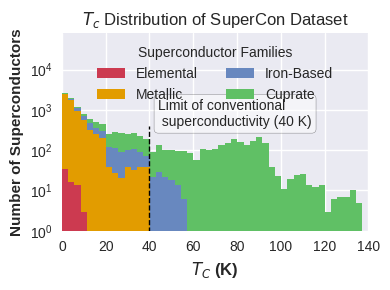

In [10]:
import os

Tc_conventional_limit = 40.0 # K (MgB2: highest Tc conventional superconductor)
Tc_high_temp = 77.0 # K (Boiling point of N2)
Tc_max = 140 # maximum critical temperature shown

# use these colors instead of the defaults:
color_dict = {
    'Elemental' : '#CC3A50',
    'Metallic' : '#E29C00',
    'Iron-Based' : '#6888BF',
    'Cuprate' : '#60C065'
}

# compile plot information for each family:
class_names = list(families.keys())
class_colors = [color_dict[n] for n in class_names ]
class_hists = [
    np.array([ mat[2] for mat in families[name] ])
    for name in class_names
]

# draw plot:
plt.figure(figsize=(4,3))
plt.hist(class_hists, bins=50, log=True, stacked=True, 
         color=class_colors, label=class_names)
plt.legend(loc='upper center', ncol=2, edgecolor='0.0', framealpha=0.5, title='Superconductor Families')
plt.ylabel('Number of Superconductors', fontsize=11, fontweight='bold')
plt.xlabel('$T_C$ (K)', fontsize=12, fontweight='bold')
plt.ylim(1, 8*10**4)
plt.xlim(0, Tc_max)


# indicate conventional Tc limit:
Tc_conventional_N = 4 * 10**2
plt.plot([Tc_conventional_limit]*2, [-1.0, Tc_conventional_N], 'k--', linewidth=1)
plt.annotate('Limit of conventional \n superconductivity '
             + f'({int(Tc_conventional_limit)} K)',
              (Tc_conventional_limit + 4, Tc_conventional_N),
             bbox=dict(boxstyle='round', fc='1.0', alpha=0.5))

plt.title('$T_c$ Distribution of SuperCon Dataset')
plt.tight_layout()

plt.show()

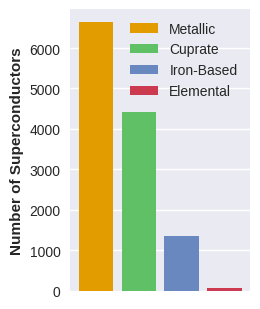

In [11]:
# plot counts for each family:
plt.figure(figsize=(2.7,3.2))
family_counts = [ (k,len(v)) for k,v in families.items() ]
family_counts.sort(key=lambda x : -x[1])

for x, (k, n) in enumerate(family_counts):
    plt.bar(x, n, label=k, color=color_dict[k])
plt.legend()
plt.gca().set_xticks([])
#plt.title('SuperCod Dataset Families')
plt.ylabel('Number of Superconductors', fontweight='bold')
plt.tight_layout()
plt.show()

## Generate Data:

In [12]:
# These are the families that will be investigated:
DATASET_FAMILIES = ['Metallic', 'Elemental']

In [13]:
# remove duplicates, etc. from formulas:
dataset_formulas = set([
    item[1] 
    for family_name in DATASET_FAMILIES
    for item in families[family_name]
])

# only use data in the DATASET_FAMILIES of interest:
dataset_families_idx = np.array([ 
    (n in dataset_formulas) 
    for n in supercon_df.name 
])

# only use data with known Tc:
known_Tc_idx = supercon_df.KnownTc

# extract data features and Tc only where Tc is defined:
data_x = np.array([
    make_formula_vector(parse_formula_tokens(f, form_re), elements)
    for f in supercon_df.name[dataset_families_idx & known_Tc_idx]
])
data_y = np.array(
    supercon_df.Tc[dataset_families_idx & known_Tc_idx]
)

print('X shape:', data_x.shape)
print('Y shape:', data_y.shape)


X shape: (6705, 118)
Y shape: (6705,)


In [14]:
from sklearn import preprocessing

# Normalize input feature vectors:
scaler_x = preprocessing.StandardScaler().fit(data_x)
scaler_y = preprocessing.StandardScaler().fit(np.expand_dims(data_y, -1))

# transform data according to normalization:
norm_data_x = scaler_x.transform(data_x)
norm_data_y = np.squeeze(scaler_y.transform(np.expand_dims(data_y, -1)))

## Visualize Principal Components:

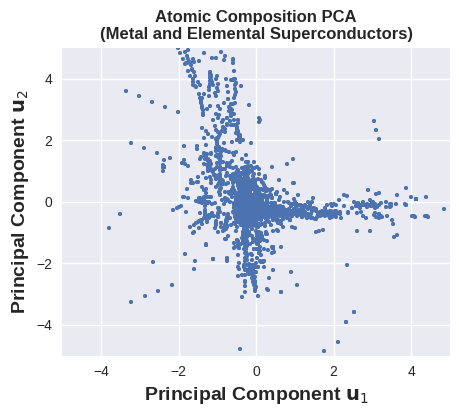

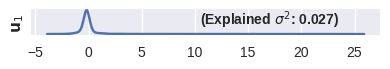

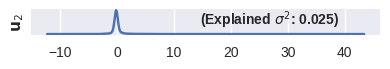

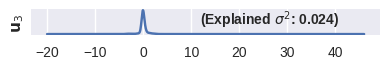

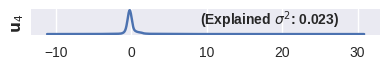

In [15]:
from sklearn.decomposition import PCA, KernelPCA
from scipy.stats import gaussian_kde


pca = PCA(n_components=4)
norm_data_pc = pca.fit_transform(norm_data_x)

# plot scatter of first 2 PCs:
pc_vis_limits = (-5,5)
plt.figure(figsize=(5,4))
plt.title('Atomic Composition PCA\n(Metal and Elemental Superconductors)',
          fontweight='bold')
plt.scatter(norm_data_pc[:,0], norm_data_pc[:,1], s=5, marker='+')
plt.xlabel(r'Principal Component $\mathbf{u}_1$',
           fontweight='bold', fontsize=14)
plt.ylabel(r'Principal Component $\mathbf{u}_2$',
           fontweight='bold', fontsize=14)
plt.xlim(*pc_vis_limits)
plt.ylim(*pc_vis_limits)
plt.show()

# plot densities of all PCs:
for i, pc_data in enumerate(norm_data_pc.T):
    kde = gaussian_kde(pc_data)
    x = np.linspace(np.min(pc_data), np.max(pc_data), 1000)
    rho = kde(x)
    plt.figure(figsize=(4,0.8))
    plt.plot(x, rho)
    plt.yticks([])
    plt.annotate(f'(Explained $\sigma^2$: {pca.explained_variance_ratio_[i]:.3f})',
                 (0.5,0.56), xycoords='figure fraction', fontweight='bold')
    plt.ylabel(r'$\mathbf{u}_'+f'{i+1}'+r'$', fontweight='bold')
    plt.tight_layout()
    plt.show()

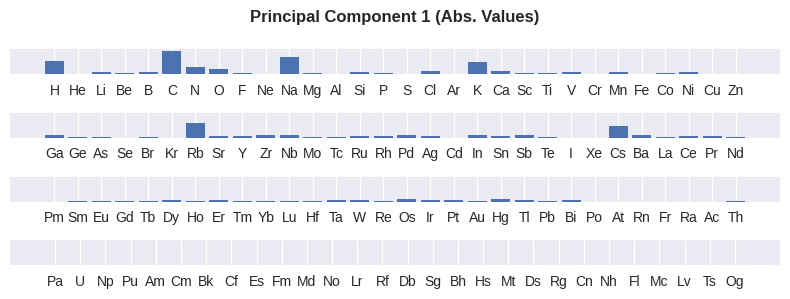

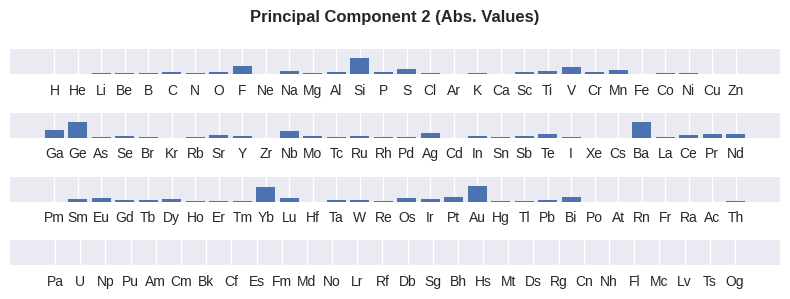

In [16]:
N_PC_BAR_PLOTS = 2

# plot bar plots of absolute values of PC components:
elems_per_row = 30
n_rows = (len(elements) // elems_per_row) + 1
for u_i in range(N_PC_BAR_PLOTS):
    fig, axs = plt.subplots(n_rows,1, figsize=(8,3))
    fig.suptitle(f'Principal Component {u_i+1} (Abs. Values)', fontweight='bold')
    
    for i in range(n_rows):
        start, end = i*elems_per_row, min(len(elements),(i+1)*elems_per_row)
        row_elements = elements[start:end]
        row_components = pca.components_[u_i,start:end]
        elems_x = np.arange(len(row_components))
        axs[i].set_ylim(0.0, 0.6)
        axs[i].bar(elems_x, np.abs(row_components))
        axs[i].set_xticks(elems_x)
        axs[i].set_xticklabels(row_elements)
        axs[i].set_yticks([],visible=False)
    plt.tight_layout()

plt.show()

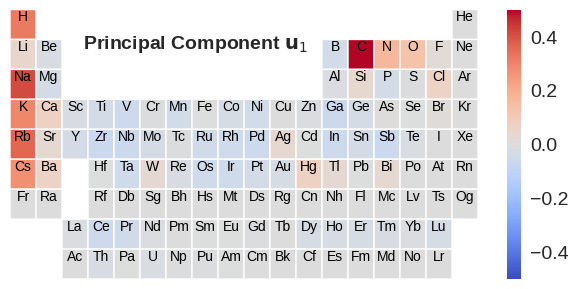

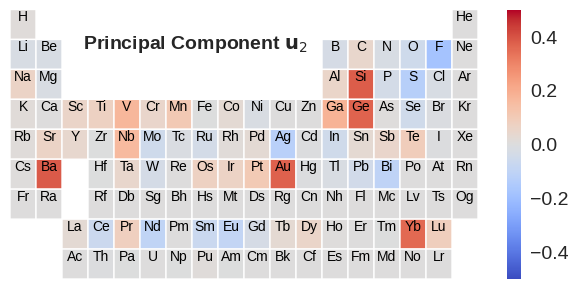

In [17]:
from pymatgen.util.plotting import periodic_table_heatmap

N_PTABLE_PLOTS = 2

# plot periodic table heatmap (better than bar plots above):
elements = ptable_df['Symbol']
for u_i in range(N_PTABLE_PLOTS):
    pc = pca.components_[u_i,:]
    ptable_dict = { elem : x for (elem, x) in zip(elements,pc)}
    periodic_table_heatmap(ptable_dict, 
                           cmap='coolwarm', 
                           symbol_fontsize=10,
                           cmap_range=(-0.5, 0.5),
                           blank_color=cm.get_cmap('coolwarm')(0.5))
    plt.gcf().set_size_inches(6,2.8)
    plt.annotate(r'Principal Component $\mathbf{u}_' + f'{u_i+1}$', (2.8,1.3), 
                 fontweight='bold', fontsize=14)
    
    plt.show()

## Support Vector Regression Modeling:


In [18]:
from sklearn.svm import NuSVR, SVR
from sklearn.model_selection import train_test_split

BASELINE_SVR_MODELS = {
    'Linear SVR'        : SVR(kernel='linear'),
    'Quadratic SVR'     : SVR(kernel='poly', degree=2),
    'Cubic SVR'         : SVR(kernel='poly', degree=3),
}

# split into train/test sets:
x_train, x_test, y_train, y_test = train_test_split(
    norm_data_x, norm_data_y, test_size=0.2)

# further split test set into validation/test set for 
# a total of an 80-10-10 split:
x_val, x_test, y_val, y_test = train_test_split(
    x_test, y_test, test_size=0.5
)


print('Train dataset size:', len(x_train))
print('Validation dataset size:', len(x_val))
print('Test dataset size:', len(x_test))

Train dataset size: 5364
Validation dataset size: 670
Test dataset size: 671


In [19]:
from tqdm import tqdm
import time

baseline_svr_data = []
svr_data_columns = ['Model','Train MAE', 'Test MAE', 'Train Time', 'Eval Time']

# fit baseline SVR models to data:
for name, model in tqdm(BASELINE_SVR_MODELS.items()):
    
    # train model:
    train_start = time.time()
    model.fit(x_train, y_train)
    train_end = time.time()
    
    # generate inferences on training and testing data:
    inference_start = time.time()
    norm_pred_y = model.predict(x_train)
    norm_pred_y_test = model.predict(x_test)
    inference_end = time.time()
    
    # unnormalize train and testing data:
    pred_y = np.squeeze(scaler_y.inverse_transform(np.expand_dims(norm_pred_y, -1)))
    pred_y_test = np.squeeze(scaler_y.inverse_transform(np.expand_dims(norm_pred_y_test, -1)))
    true_y = np.squeeze(scaler_y.inverse_transform(np.expand_dims(y_train, -1)))
    true_y_test = np.squeeze(scaler_y.inverse_transform(np.expand_dims(y_test, -1)))
    
    # compute error:
    train_mae = np.mean(np.abs(pred_y - true_y))
    test_mae = np.mean(np.abs(pred_y_test - true_y_test))
    train_time = (train_end - train_start)
    eval_time = (inference_end - inference_start)
    
    baseline_svr_data.append([ name, train_mae, test_mae, train_time, eval_time])


100%|██████████████████████████████████████████████████████████| 3/3 [00:27<00:00,  9.32s/it]


In [20]:
from tqdm import tqdm

# range of nu values (min fraction of retained support vectors):
NU_VALS = np.linspace(0.01, 0.4, 32)

# define models to be investigated:
SIGMOIDAL_MODELS = {
    nu : NuSVR(kernel='sigmoid', nu=nu)
    for nu in NU_VALS
}
RBF_MODELS = {
    nu : NuSVR(kernel='rbf', nu=nu)
    for nu in NU_VALS
}
POLY_MODELS = {
    nu : NuSVR(kernel='poly', nu=nu)
    for nu in NU_VALS
}

MODEL_NAMES = ['Sigmoid Nu-SVR', 'RBF Nu-SVR', 'Cubic Nu-SVR']
MODELS = [ SIGMOIDAL_MODELS, RBF_MODELS, POLY_MODELS]

verbose = True

nu_svr_data = []

# fit nu-SVR models to data for each nu value:
for nu in tqdm(NU_VALS):
    for name, models in zip(MODEL_NAMES, MODELS):
        
        # train model:
        model = models[nu]
        train_start = time.time()
        model.fit(x_train, y_train)
        train_end = time.time()
        
        # generate inferences on training and validation data:
        inference_start = time.time()
        norm_pred_y = model.predict(x_train)
        norm_pred_y_val = model.predict(x_val)
        norm_pred_y_test = model.predict(x_test)
        inference_end = time.time()
        
        # unnormalize train and validation data:
        pred_y = np.squeeze(scaler_y.inverse_transform(np.expand_dims(norm_pred_y, -1)))
        pred_y_val = np.squeeze(scaler_y.inverse_transform(np.expand_dims(norm_pred_y_val, -1)))
        pred_y_test = np.squeeze(scaler_y.inverse_transform(np.expand_dims(norm_pred_y_test, -1)))
        true_y = np.squeeze(scaler_y.inverse_transform(np.expand_dims(y_train, -1)))
        true_y_val = np.squeeze(scaler_y.inverse_transform(np.expand_dims(y_val, -1)))
        true_y_test = np.squeeze(scaler_y.inverse_transform(np.expand_dims(y_test, -1)))
        
        # compute error:
        train_mae = np.mean(np.abs(pred_y - true_y))
        val_mae = np.mean(np.abs(pred_y_val - true_y_val))
        test_mae = np.mean(np.abs(pred_y_test - true_y_test))
        train_time = (train_end - train_start)
        eval_time = (inference_end - inference_start)
        nu_svr_data.append([ 
            name, nu, 
            train_mae, val_mae, test_mae, 
            train_time, eval_time 
        ])
        
# format results into dataframe:
nu_svr_df = pd.DataFrame(nu_svr_data, columns=[
    'Model', 'Nu', 
    'Train MAE', 'Validation MAE', 'Test MAE',
    'Train Time', 'Eval Time'
]).sort_values(by=['Model', 'Nu'])

100%|████████████████████████████████████████████████████████| 32/32 [10:10<00:00, 19.07s/it]


In [23]:
svr_data = baseline_svr_data.copy()

for model in MODEL_NAMES:
    model_instances = nu_svr_df[nu_svr_df.Model == model]
    best_instance = model_instances[
                        model_instances['Validation MAE'] == \
                        model_instances['Validation MAE'].min()
                    ]
    svr_data.append(best_instance[svr_data_columns].iloc[0])

# compute MAD:
true_y_test = np.squeeze(scaler_y.inverse_transform(np.expand_dims(y_test, -1)))
test_mad = np.mean(np.abs(true_y_test - np.mean(true_y_test)))

print('MAD of test data:', test_mad)
svr_df = pd.DataFrame(svr_data, columns=svr_data_columns)
svr_df['Test MAD/MAE'] = (test_mad / svr_df['Test MAE'])
svr_df # view in notebook

MAD of test data: 4.753140997439749


,Model,Train MAE,Test MAE,Train Time,Eval Time,Test MAD/MAE
0,Linear SVR,3.854396,3.965179,16.265810,1.210789,1.198720
1,Quadratic SVR,3.543892,4.127429,3.519551,1.513819,1.151598
2,Cubic SVR,3.632600,4.887312,3.848821,1.586593,0.972547
3,Sigmoid Nu-SVR,13.191058,12.217422,0.730460,0.278743,0.389046
4,RBF Nu-SVR,3.077113,3.255336,1.398366,1.203823,1.460108
5,Cubic Nu-SVR,4.027172,4.967053,28.833146,0.694679,0.956934


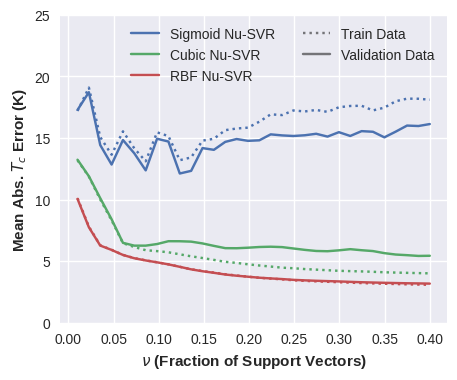

In [28]:
model_types = set(nu_svr_df['Model'])

plt.figure(figsize=(5,4))
for model in model_types:
    model_df = nu_svr_df[nu_svr_df['Model'] == model]
    model_df = model_df.sort_values(by='Nu')
    nu_values = model_df['Nu']
    train_mae = model_df['Train MAE']
    val_mae = model_df['Validation MAE']
    line, = plt.plot(nu_values, train_mae, ':')
    plt.plot(nu_values, val_mae, color=line.get_color(), label=f'{model}')

plt.plot([],[], ':k', alpha=0.5, label='Train Data')
plt.plot([],[], 'k', alpha=0.5, label='Validation Data')
plt.ylim(0,25)
plt.ylabel(r'Mean Abs. $T_c$ Error (K)', fontweight='bold')
plt.xlabel(r'$\nu$ (Fraction of Support Vectors)', fontweight='bold')
plt.legend(ncol=2)
plt.show()
    